In [1]:
from pathlib import Path
from shapely.geometry import LineString
import numpy as np
import numpy.linalg as la
import ipywidgets as ipyw
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
#from pydicom.filereader import read_dicomdir

In [2]:
## A few useful functions for visualization

class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices| in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Arguments:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('gray'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, 
                 volume,
                 slicelocations,
                 figsize=(100,100), 
                 cmap='gray', 
                 v=None, 
                 aspect=None
    ):
        self.volume = volume
        self.slicelocations = slicelocations
        self.figsize = figsize
        self.cmap = cmap
        if v is None:
            self.v = [np.min(volume), np.max(volume)]
        else:
            self.v = v
        
        if aspect is None:
            self.aspect = 1
        else:
            self.aspect = aspect
        
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.vol1 = np.transpose(self.volume, [1,2,0])
        self.vol2 = np.rot90(np.transpose(self.volume, [2,0,1]), 3) #rotate 270 degrees
        self.vol3 = np.transpose(self.volume, [0,1,2])
        maxZ1 = self.vol1.shape[2] - 1
        maxZ2 = self.vol2.shape[2] - 1
        maxZ3 = self.vol3.shape[2] - 1
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(value = maxZ1//2, min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(value = maxZ2//2, min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(value = maxZ3//2, min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))

    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.vol1[:,:,z1], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = 1)
        ax[1].imshow(self.vol2[:,:,z2], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = self.aspect)
        ax[2].imshow(self.vol3[:,:,z3], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = self.aspect)
        plt.show()
        

In [5]:
# Let us load some CT data (in DICOM format) and display it
directory = 'DICOM Data/CT'
list_of_files = [ file for file in Path(directory).iterdir() if file.suffix == ".dcm" ]
filtered_list = filter(lambda x: pydicom.dcmread(x).Modality == "CT", list_of_files)
sorted_list = sorted(filtered_list, key=lambda x: pydicom.dcmread(x,force=True).InstanceNumber)

print('Path to the DICOM directory: {}'.format(directory))

#get the pixel array
datasets = [pydicom.dcmread(image_filename).pixel_array
                        for image_filename in sorted_list]
slicelocations = np.array([pydicom.dcmread(image_filename).SliceLocation
                        for image_filename in sorted_list])

#convert to numpy array
ds = pydicom.dcmread(sorted_list[0])
aspect = ds.SliceThickness / ds.PixelSpacing[0]
npa = np.array(datasets)
ImageSliceViewer3D(volume=npa, 
                   slicelocations=slicelocations ,
                   v=[500,1500], 
                   aspect=aspect)

Path to the DICOM directory: DICOM Data/CT


interactive(children=(Output(),), _dom_classes=('widget-interact',))

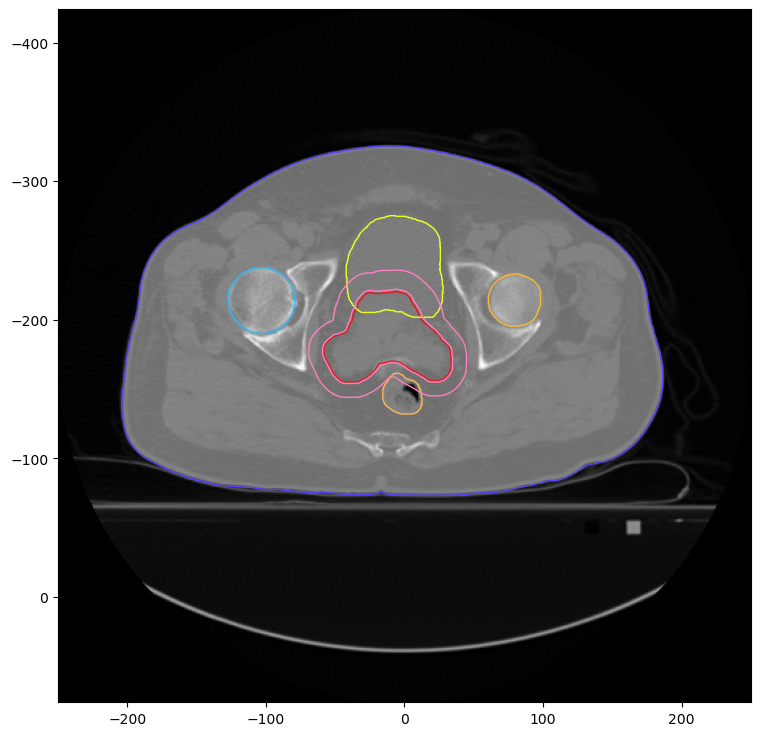

In [6]:
# Let us pick a slice for our (2D, for simplicity) therapy planning

slice_num = 110

# CT Dataset
directory = 'DICOM Data/CT'
list_of_files = [ file for file in Path(directory).iterdir() if file.suffix == ".dcm" ]
filtered_list = filter(lambda x: pydicom.dcmread(x).Modality == "CT", list_of_files)
sorted_list = sorted(filtered_list, key=lambda x: pydicom.dcmread(x,force=True).InstanceNumber)
slicelocations = np.array([pydicom.dcmread(image_filename).SliceLocation
                        for image_filename in sorted_list])
z = slicelocations[slice_num]

# Structure Set
ss = Path('DICOM Data/RS1.2.752.243.1.1.20220223090558739.4000.72166.dcm')
dss = pydicom.dcmread(ss)

roi_list = ["PTV_p", "Bladder", "Rectum", "Femur_Head_L", "Femur_Head_R","Ring_HD", "ExternalClean"]

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Plot CT slice
for file in sorted_list:
    ds = pydicom.dcmread(file)
    if ds.SliceLocation == z:
        pixel_data = ds.pixel_array

extent = [
    ds.ImagePositionPatient[0] - ds.PixelSpacing[0]/2,
    ds.ImagePositionPatient[0] + (ds.Columns-1)*ds.PixelSpacing[0] + ds.PixelSpacing[0]/2,
    ds.ImagePositionPatient[1] + (ds.Rows-1)*ds.PixelSpacing[1] + ds.PixelSpacing[1]/2,
    ds.ImagePositionPatient[1] - ds.PixelSpacing[1]/2,
]

ax.imshow(pixel_data, extent=extent,cmap="gray")

roi_dict = {}

# Plot Structures
for roi_label in roi_list:
    
    roi_dict[roi_label] = []
    # Find the ROI number
    
    roi_number = None
    for dcm_roi in dss.StructureSetROISequence:
        if dcm_roi.ROIName == roi_label:
            roi_number = dcm_roi.ROINumber
     
    
    assert roi_number is not None, f"Could not find {roi}"
    
    # Get the ROI Contours
    roi = None
    for roi_contour_item in dss.ROIContourSequence:
        if roi_contour_item.ReferencedROINumber == roi_number:
            roi = roi_contour_item
    
    roi_color = roi.ROIDisplayColor
    roi_contour_stack = roi.ContourSequence
    
    for contour in roi_contour_stack:
        list_of_points = np.reshape(contour.ContourData, (contour.NumberOfContourPoints,3))
        if list_of_points[0,2] == z:
            roi_dict[roi_label].append(list_of_points)
            x=list_of_points[:,0]
            y=list_of_points[:,1]
            ax.fill(x, y, facecolor='none', edgecolor=np.array(roi_color)/256)
        

In [9]:
# This is information related to the current plan
plan = Path('DICOM Data/RP1.2.752.243.1.1.20220223092421606.1900.15058.dcm')
dsp = pydicom.dcmread(plan)
for beam in dsp.BeamSequence:
    cp1 = beam.ControlPointSequence[0]
    print(f"Beam {beam.BeamNumber} has a gantry angle of {cp1.GantryAngle}")
    
exter = roi_dict["ExternalClean"][0][::20,0:2]
isocenter = cp1.IsocenterPosition  
print(f"Isocenter is located at {isocenter}")

Beam 1 has a gantry angle of 210
Beam 2 has a gantry angle of 260
Beam 3 has a gantry angle of 310
Beam 4 has a gantry angle of 0
Beam 5 has a gantry angle of 50
Beam 6 has a gantry angle of 100
Beam 7 has a gantry angle of 150
Isocenter is located at [-11.32453, -195.2993, -632.4196]


# Analytical model for dose calculation
The equation from AAPM TG-71 for monitor unit calculation of beams for the SAD technique is:
$$ 
MU = \frac{D}{\dot{D}_0 \times S_c(r_c) \times S_p(r_d) \times \mathrm{TPR}(d,r_d) \times \mathrm{WF}(d,r_d,x) \times \mathrm{TF} \times \mathrm{OAR}(d,x) \times \left(\frac{\mathrm{SSD}_0 + d_0}{\mathrm{SPD}}\right)^2 }
$$

We make the following simplifying assumptions:
* $\dot{D}_0$ is 1 cGy/MU under reference conditions:
    * 10x10 field
    * $\mathrm{SSD}_0$ = 100 cm SSD
    * $d_0$ = depth of maximum dose = 2.3 cm (10 MV photons)
* $S_c(r_c) = 1$ and $S_p(r_d) = 1$ (ignore field size)
* $\mathrm{TPR}(d,r_d)$ is the tabulated TMR for a 10 MV photon beam, 6x6 cm field, found at in Khan The Physics of Treatment Planning (4th ed., page A-19)
* $\mathrm{WF}(d,r_d,x) = 1$ No wedges
* $\mathrm{TF}= 1$ No tray
* $\mathrm{OAR}(d,x) = 1$ Our beam profiles are perfectly flat

The equation simplifies to:
$$ 
MU = \frac{D}{\mathrm{TPR}(d) \times \left(\frac{102.3 cm}{\mathrm{SPD}}\right)^2 }
$$

Solving for dose:
$$ 
D = MU \times \mathrm{TPR}(d) \times \left(\frac{102.3 cm}{\mathrm{SPD}}\right)^2
$$

Where:
* $d$ is the depth of the point in the patient, and:
* SPD is the source to point distance

The tabulated TPR is in the cell below

In [12]:
# Simple model for dose deposition as a function of distance once the photons hit the body
TMR_10MV_6x6 = np.array(
    [
        [0,0.081],
        [0.2,0.411],
        [0.5,0.663],
        [1,0.864],
        [1.5,0.941],
        [2,0.97],
        [2.5,1],
        [3,1],
        [4,0.992],
        [5,0.963],
        [6,0.934],
        [7,0.906],
        [8,0.878],
        [9,0.851],
        [10,0.824],
        [11,0.798],
        [12,0.773],
        [13,0.749],
        [14,0.725],
        [15,0.701],
        [16,0.678],
        [17,0.626],
        [18,0.634],
        [19,0.613],
        [20,0.593],
        [22,0.553],
        [24,0.516],
        [26,0.481],
        [28,0.448],
        [30,0.417],
        [40,0.262], # A linear extrapolation of the last two points      
    ]
)

def TMR(depth):
    """
    Returns the TMR for a 10 MV, 6x6 cm field for the provided depth
    
    ----------
    PARAMETERS
    ----------
    depth: float
        The depth, in cm
        
    -------
    RETURNS
    -------
    The TPR, expressed as a fraction
    
    """
    
    assert depth >= 0, "Depth must be a non-negative number"
    assert depth <= 40, "Depth must be less than 40 cm"
    
    depths = TMR_10MV_6x6[:,0]
    TPRs = TMR_10MV_6x6[:,1]
    
    return np.interp(depth, depths, TPRs) 
    

def SPD(point, isocenter, gantry_angle):
    """
    Returns the source-to-point distance, in cm
    
    ----------
    PARAMETERS
    ----------
    point: list of float
        The x,y,z location of the point of interest, in DICOM coordinates (mm)
    isocenter: list of float
        The x,y,z location of the isocenter, in DICOM coordinates (mm)
    gantry_angle: float
        The gantry angle
        
    -------
    RETURNS
    -------
    The SPD, in cm
    
    -----
    NOTES
    -----
    There are million ways this function could break, 
    mostly due to incorrect calculation of the source location
    
    """
    
    point_x = point[0]
    point_y = point[1]
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    return np.sqrt((point_x-source_x)**2 + (point_y-source_y)**2)/10

def get_depth(point, isocenter, gantry_angle, external):
    """
    Returns the depth of the point, in cm
    
    ----------
    PARAMETERS
    ----------
    point: list of float
        The x,y,z location of the point of interest, in DICOM coordinates (mm)
    isocenter: list of float
        The x,y,z location of the isocenter, in DICOM coordinates (mm)
    gantry_angle: float
        The gantry angle
    external: np.array
        The output of roi_dict["ExternalClean"][0], which gives the list of points that define the external contour
        
    -------
    RETURNS
    -------
    The depth, in cm
    
    -----
    NOTES
    -----
    
    
    """
    point_x = point[0]
    point_y = point[1]
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    
    # Now you have the source and point location. From here, you need to figure one:
    # 1. What is the intersection between the source-point line, and [Guessing this means intersection with the body?]
    # 2. What is the distance between the the intersection point and the point of interest (depth)
    mypoly = external[:,0:2]
    #print(mypoly)
    
    l = LineString([[source_x,source_y], [point_x,point_y]])

#    int_pt = line1.intersection(line2)
#    point_of_intersection = int_pt.x, int_pt.y

    inter = []
    for k in range(mypoly.shape[0]):
        mypoly2 = mypoly[[(k-1),k],:]
        t = LineString(mypoly2)
        a = t.intersection(l)
        if a.is_empty == False:
            inter.append(a)

    if len(inter) == 1:
        depth = np.sqrt(float((inter[0].x - point_x)**2 + (inter[0].y - point_y)**2))/10
    else:
        depth = 1000
    
    
    return depth



In [14]:
# Let us calculate the pixels affected by a given beamlet and gantry angle
def calculate_beamlets(isocenter, gantry_angle, beam_angle, total_beamlets, ds):
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    # Let's calculate the total beam first, start with the edges
    v0_x = iso_x - source_x
    v0_y = iso_y - source_y
    v1_x = v0_x*np.cos(np.pi*beam_angle/2/180) + v0_y*np.sin(np.pi*beam_angle/2/180)
    v1_y = v0_y*np.cos(np.pi*beam_angle/2/180) - v0_x*np.sin(np.pi*beam_angle/2/180)
    v2_x = v0_x*np.cos(np.pi*beam_angle/2/180) - v0_y*np.sin(np.pi*beam_angle/2/180)
    v2_y = v0_y*np.cos(np.pi*beam_angle/2/180) + v0_x*np.sin(np.pi*beam_angle/2/180)

    #
    xvals = iso_x + (np.arange(ds.Rows) - ds.Rows/2)*ds.PixelSpacing[0]
    yvals = iso_y + (np.arange(ds.Columns) - ds.Columns/2)*ds.PixelSpacing[1]
    xvals = xvals[::4]
    yvals = yvals[::4]
    
    xv,yv = np.meshgrid(xvals,yvals)
    
    #plt.imshow(yv)
    #plt.colorbar()
    
    # Segment out main beam, for test
    dx = xv - source_x
    dy = yv - source_y
    allangles = np.arccos((dx*v0_x + dy*v0_y)/(np.sqrt((v0_x**2 + v0_y**2)*(dx**2 + dy**2))))
    in_beam = abs(allangles)<np.pi*beam_angle/2/180
    
    # Segment out kth beamlet, for test
    angle_ranges = np.linspace(-beam_angle/2, beam_angle/2, total_beamlets+1)
    mask_beam = np.zeros([ds.Rows,ds.Columns,total_beamlets] , dtype=bool)
    mask_beam = np.zeros([128, 128,total_beamlets] , dtype=bool)
    for k in range(total_beamlets):
        curangle = 0.5*(angle_ranges[k] + angle_ranges[k+1])
        vk_x = v0_x*np.cos(np.pi*curangle/180) + v0_y*np.sin(np.pi*curangle/180)
        vk_y = v0_y*np.cos(np.pi*curangle/180) - v0_x*np.sin(np.pi*curangle/180)
        allangles = np.arccos((dx*vk_x + dy*vk_y)/(np.sqrt((vk_x**2 + vk_y**2)*(dx**2 + dy**2))))
        in_beam = abs(allangles)<np.pi*beam_angle/total_beamlets/2/180
        mask_beam[:,:,k] = in_beam
    
    return mask_beam

In [16]:
# Let us define some parameters for our IMRT system
beam_angle = 7
total_beamlets = 21
gantry_angle = 0
mask_beam = calculate_beamlets(isocenter, gantry_angle, beam_angle, total_beamlets, ds);

In [18]:
# Create masks for each of our beamlets and gantry angles
allmasks = []
gantry_angles = []
for beam in dsp.BeamSequence:
    cp1 = beam.ControlPointSequence[0]
    print(f"Generating beamlets for beam {beam.BeamNumber}, with a gantry angle of {cp1.GantryAngle}.")
    gantry_angles.append(cp1.GantryAngle)
    mask_beam = calculate_beamlets(isocenter, cp1.GantryAngle, beam_angle, total_beamlets, ds);    
    allmasks.append(mask_beam) 
    
#plt.imshow(allmasks[3][:,:,4])

Generating beamlets for beam 1, with a gantry angle of 210.
Generating beamlets for beam 2, with a gantry angle of 260.
Generating beamlets for beam 3, with a gantry angle of 310.
Generating beamlets for beam 4, with a gantry angle of 0.
Generating beamlets for beam 5, with a gantry angle of 50.
Generating beamlets for beam 6, with a gantry angle of 100.
Generating beamlets for beam 7, with a gantry angle of 150.


In [20]:
# Calculate dose deposited at selected pixels within beamlet for a given gantry (source) location
def calculatedose(source, curmask, xvals, yvals, isocenter, gantry_angle, external):
    
    source_x = source[0]
    source_y = source[1]
    
    curdose = np.zeros(xv.shape)
    
    beamlocs = np.where(curmask)
        
    tempdose = np.zeros(beamlocs[0].shape)
    for k in range(len(beamlocs[0])):
        curx = xvals[beamlocs[1][k]]
        cury = yvals[beamlocs[0][k]]
        depth = get_depth([curx,cury], isocenter, gantry_angle, external)
        if depth < 40:
            #print([curx,cury,isocenter,gantry_angle,depth])
            tempdose[k] = TMR(depth)
            #print([curx,cury,isocenter,gantry_angle,depth, TMR(depth)])
            #tempdose[k] = depth
    
    curdose[beamlocs] = tempdose
    
    return curdose

In [22]:
# Calculate the dose deposition matrix D (stored in 4D array alldms)

# Compute the source location
iso_x = isocenter[0]
iso_y = isocenter[1]

# In image coordinates
# 0 degrees is 100 cm more negative in the y direction
# 180 degrees is 100 cm more positive in the y direction
# 90 degrees is 100 cm more positive in the x direction
# 270 degrees is 100 cm more negative in the x direction
gantry_radians = np.pi*(gantry_angle/180)
source_x = iso_x + 1000*np.sin(gantry_radians)
source_y = iso_y - 1000*np.cos(gantry_radians)

# Create our 2D grids of x and y locations, in physical units [mm]
xvals = iso_x + (np.arange(ds.Rows) - ds.Rows/2)*ds.PixelSpacing[0]
yvals = iso_y + (np.arange(ds.Columns) - ds.Columns/2)*ds.PixelSpacing[1]
xvals = xvals[::4]
yvals = yvals[::4]

xv,yv = np.meshgrid(xvals,yvals)

# Run forward problem given some fluence values
num_gantry_angles = len(gantry_angles)
fluence = np.random.rand(num_gantry_angles,total_beamlets)
dosemap = np.zeros([ds.Rows,ds.Columns])
dosemap = np.zeros([128,128])

# Create the 4D array alldms, which contains the information for the 
# dose deposition matrix. Specifically, alldms[:,:,kgan,kbeam] contains
# the dose deposition map (first two dimensions) resulting from a 
# unit fluence at gantry angle kgan, and beamlet kbeam 
alldms = np.zeros([128, 128,num_gantry_angles, total_beamlets ])
for kgan in range(num_gantry_angles):
    for kbeam in range(total_beamlets):
        curmap = calculatedose([source_x,source_y], allmasks[kgan][:,:,kbeam], xvals, yvals, isocenter, gantry_angles[kgan], exter)
        dosemap = dosemap + fluence[kgan,kbeam]*curmap
        alldms[:,:,kgan,kbeam] = curmap


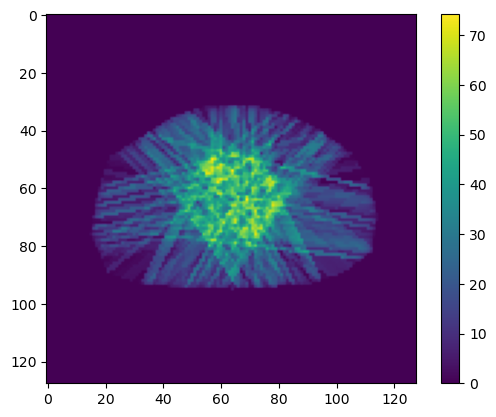

In [23]:
# Calculate dose map for a randomly chosen fluence map

fluence = 20*np.random.rand(num_gantry_angles,total_beamlets)
dosemap = np.zeros([128,128])
for kgan in range(num_gantry_angles):
    for kbeam in range(total_beamlets):
        dosemap = dosemap + fluence[kgan,kbeam]*alldms[:,:,kgan,kbeam]
        

plt.imshow(dosemap,vmin=0)
plt.colorbar();


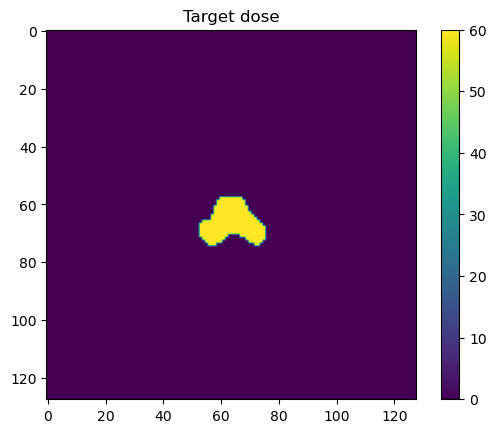

In [38]:
# Let's set up our optimization problem
# Create the desired dose distribution
ptv = roi_dict["PTV_p"][0][:,0:2]
from matplotlib import path
p = path.Path(ptv)  # Path describing our target volume
xypoints = np.concatenate((xv.reshape(128*128,1), yv.reshape(128*128,1)), axis=1);
mask_ptv = p.contains_points(xypoints).reshape((128,128));

# Here's the target dose we are trying to achieve
b = 60*mask_ptv # Target dose

## Let's create some weights describing which regions we care about the most
Femur_Head_R = roi_dict["Femur_Head_R"][0][:,0:2]
p = path.Path(Femur_Head_R)  # Path describing a region we wish to protect
mask_femur_r = p.contains_points(xypoints).reshape((128,128));
Femur_Head_L = roi_dict["Femur_Head_L"][0][:,0:2]
p = path.Path(Femur_Head_L)  # Path describing a region we wish to protect
mask_femur_l = p.contains_points(xypoints).reshape((128,128));
Rectum = roi_dict["Rectum"][0][:,0:2]
p = path.Path(Rectum)  # Path describing a region we wish to protect
mask_rectum = p.contains_points(xypoints).reshape((128,128));
weights = np.ones((128,128))
weights[mask_femur_l] = 5
weights[mask_femur_r] = 5
weights[mask_rectum] = 5
weights[mask_ptv] = 10

plt.imshow(b)
plt.colorbar();
plt.title("Target dose");

## Implement SD therapy planning without constraints

The fluence optimization problem can be posed as the following linear least-squares (LLS) problem:


$$\mathbf{x^*} = \arg \min_{\mathbf{x}} \| \mathbf{Dx}  - \mathbf{d} \|_2^2$$

where $\mathbf{x}$ is the fluence map we are trying to determine (i.e., the fluence applied for each beamlet within each gantry angle), $\mathbf{D}$ is the dose deposition matrix, which converts the fluence map into a dose deposition map, and $\mathbf{d}$ is the desired dose deposition map. In this homework set, we will consider a desired dose deposition of 60 Gy within the target volume, and 0 Gy elsewhere.

Note that the action of the matrix $D$ is captured by the 4D array *alldms* in this notebook. This array has size sx $\times$ sy $\times$ gantry angles $\times$ beamlets, so for example the subarray alldms$[:,:,3,4]$ contains the dose deposition map resulting from applying a fluence of $1$ at the beamlet number 4 within the gantry angle number 3 (note that these indices start at 0). In other words, we have all the information needed to calculate the effect of $\mathbf{D}$ on a (vectorized) fluence map $\mathbf{x}$, but the way our arrays are organized is not appropriate for direct matrix-vector multiplication. 

*Task:* implement a steepest descent algorithm to solve this LLS problem for the conditions given in the associated jupyter notebook.

*Questions:* 

i. Does the solution of this LLS problem produce a dose deposition map that resembles the desired map? In what ways is it similar and in what ways is it different? 

ii. Does the solution violate any reasonable physical constraints? For example, any beamlets with negative fluence or pixels with negative dose? 

iii. Could we simply fix our solution by setting any negative fluence values to zero? What would be the advantages and disadvantages of this approach?  





In [ ]:
# Need to implement two functions, one that calculates the value of f(x) = || Dx-d ||^2, 
# and another one that calculates its gradient (ie: the vector of partial derivatives)


# Then we may want to implement a golden section search function which, given 
# the current guess xk and search direction (-gradient) gives us the step size


# Finally, we should implement SD:
# 1. Initialize with some initial guess, eg: x^[0] = all zeroes
# 2. For each iteration:
#      i. Calculate gradient at current guess x^[k]
#     ii. Calculate step size alpha that minimizes the function along the line (x^[k] - alpha.gradient)
#    iii. Update x^[k+1] = x^[k] - alpha^* . gradient
# 3. Stop when the gradient is small enough, or x^[k+1] - x^[k] is small enough, 
#    or we have run some max number of iterations

## Positivity-constrained formulation

The previous formulation can be refined by including positivity constraints on the fluence map, as follows:


$$\begin{array}{cl}
\mathbf{x^*} = \arg \min_{\mathbf{x}} &  \| \mathbf{Dx}  - \mathbf{d} \|_2^2 \\
\hbox{subject to} & x_n \geq 0 \hbox{, for } n=1,\ldots,N
\end{array}$$


*Task:* implement a steepest descent algorithm to solve this constrained LLS problem for the conditions given in the associated jupyter notebook. To enforce the positivity constraints, you can try one of several strategies, such as:

- Project the result of each iteration back to the feasible region. In other words, after each SD iteration $k$, find any negative entries in $\mathbf{x^{(k)}}$ and set those entries to zero before moving on to the next iteration. 

- Project the descent direction to make sure if points in a feasible direction. In other words, if any entries in $\mathbf{x^{(k)}}$ are zero, and the corresponding entries in the descent direction vector $-\nabla f(\mathbf{x^{(k)}})$ are negative, set these entries to zero in the descent direction. This will also require checking the positivity constraint during the line search portion of each iteration, or projecting the outcome of each iteration back to the feasible region as described above. 

*Questions:* 

i. Does the solution of this LLS problem produce a dose deposition map that resembles the desired map? In what ways is it similar and in what ways is it different? 

ii. Does the solution violate any reasonable physical constraints? For example, any beamlets with negative fluence or pixels with negative dose? 

iii. How does the value of the cost function at the solution of the constrained problem compare to the value of the cost function at the solution to the unconstrained problem described above? 



In [34]:
## Apply SD with positivity constraints, by modifying the code for the previous question
targetdose = 60*mask_ptv # Target dose is 60 in the lesion, 0 elsewhere
weights = np.ones((128,128)) # No weighting here (weights are all 1's)
wtargetdose = weights*targetdose # In case we use weights for different regions


## Positivity-constrained, weighted formulation

The previous formulation can be refined by including weights on the cost function, to encode our desire to protect certain organs, as follows:


$$\begin{array}{cl}
\mathbf{x^*} = \arg \min_{\mathbf{x}} &  \| \mathbf{W} ( \mathbf{Dx}  - \mathbf{d} ) \|_2^2 \\
\hbox{subject to} & x_n \geq 0 \hbox{, for } n=1,\ldots,N
\end{array}$$

where $\mathbf{W}$ is a positive diagonal matrix that defines how much we care about matching the desired dose at each pixel. Note that in the following cell we only give the diagonal entries of $\mathbf{W}$ in an array termed *weights*. 


*Task:* implement a steepest descent algorithm to solve this constrained weighted LLS problem for the conditions given in the associated jupyter notebook. 

*Question:* How does this solution (dose deposition map) compare to the previous unweighted solution? 




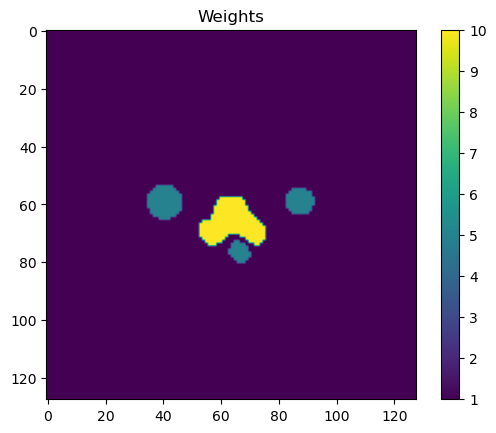

In [42]:
## Apply SD with positivity constraints and a weighted LS formulation, 
## by modifying the code for the previous question

## Let's create some weights describing which regions we care about the most
Femur_Head_R = roi_dict["Femur_Head_R"][0][:,0:2]
p = path.Path(Femur_Head_R)  # Path describing a region we wish to protect
mask_femur_r = p.contains_points(xypoints).reshape((128,128));
Femur_Head_L = roi_dict["Femur_Head_L"][0][:,0:2]
p = path.Path(Femur_Head_L)  # Path describing a region we wish to protect
mask_femur_l = p.contains_points(xypoints).reshape((128,128));
Rectum = roi_dict["Rectum"][0][:,0:2]
p = path.Path(Rectum)  # Path describing a region we wish to protect
mask_rectum = p.contains_points(xypoints).reshape((128,128));
weights = np.ones((128,128))
weights[mask_femur_l] = 5
weights[mask_femur_r] = 5
weights[mask_rectum] = 5
weights[mask_ptv] = 10

## Here's the target dose (and a version multiplied by the weights)
targetdose = 60*mask_ptv # Target dose is 60 in the lesion, 0 elsewhere
wtargetdose = weights*targetdose # In case we use weights for different regions


plt.imshow(weights)
plt.colorbar();
plt.title("Weights");

## More beamlets

Now let us try solving the problem described in the previous question, but let us devote more resources to try to match the desired dose deposition more closely. Specifically, let us use 21 gantry angles, with 31 beamlets per angle. 

*Task:* implement a steepest descent algorithm to solve this constrained weighted LLS problem for the current enhanced conditions. 

*Questions:*

i. How does this solution (dose deposition map) compare to the previous unweighted solution? 

ii. How does the computation time compare between solving this (bigger) problem and the previous (smaller) one?


In [32]:
# Let us define some enhanced parameters for our IMRT system
beam_angle = 11
total_beamlets = 41

# Create masks for the spatial extent of each beamlet
allmasks = []
num_gantry_angles = 21
gantry_angles = np.linspace(0, 360, num=num_gantry_angles, endpoint=False)
for ka in range(num_gantry_angles):
    #    print(f"Generating beamlets for beam {ka}, with a gantry angle of {gantry_angles[ka]}.")
    mask_beam = calculate_beamlets(isocenter, gantry_angles[ka], beam_angle, total_beamlets, ds);    
    allmasks.append(mask_beam) 
    
#plt.imshow(allmasks[3][:,:,4])

# Compute the source location relative to isocenter
iso_x = isocenter[0]
iso_y = isocenter[1]

# In image coordinates
# 0 degrees is 100 cm more negative in the y direction
# 180 degrees is 100 cm more positive in the y direction
# 90 degrees is 100 cm more positive in the x direction
# 270 degrees is 100 cm more negative in the x direction
gantry_radians = np.pi*(gantry_angle/180)
source_x = iso_x + 1000*np.sin(gantry_radians)
source_y = iso_y - 1000*np.cos(gantry_radians)

# Create our 2D grids of x and y locations, in physical units [mm]
xvals = iso_x + (np.arange(ds.Rows) - ds.Rows/2)*ds.PixelSpacing[0]
yvals = iso_y + (np.arange(ds.Columns) - ds.Columns/2)*ds.PixelSpacing[1]
xvals = xvals[::4]
yvals = yvals[::4]

xv,yv = np.meshgrid(xvals,yvals)

# Run forward problem given some fluence values
num_gantry_angles = len(gantry_angles)
fluence = np.random.rand(num_gantry_angles,total_beamlets)
dosemap = np.zeros([ds.Rows,ds.Columns])
dosemap = np.zeros([128,128])

# Create the 4D array alldms, which contains the information for the 
# dose deposition matrix. Specifically, alldms[:,:,kgan,kbeam] contains
# the dose deposition map (first two dimensions) resulting from a 
# unit fluence at gantry angle kgan, and beamlet kbeam 
alldms = np.zeros([128, 128,num_gantry_angles, total_beamlets ])
for kgan in range(num_gantry_angles):
    for kbeam in range(total_beamlets):
        curmap = calculatedose([source_x,source_y], allmasks[kgan][:,:,kbeam], xvals, yvals, isocenter, gantry_angles[kgan], exter)
        dosemap = dosemap + fluence[kgan,kbeam]*curmap
        alldms[:,:,kgan,kbeam] = curmap


In [33]:
# Now apply the algorithm from the previous question to the new enhanced conditions
# And compare (visually or quantitatively) the resulting dose deposition maps